In [1]:
#library
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

info = pd.read_csv("asset_details.csv")
ctrain = pd.read_csv("train.csv")

**Color Scheme**

In [2]:
sns.color_palette("YlOrBr", 10)

[(1.0, 0.977362552864283, 0.7820222991157247),
 (0.9982622068435217, 0.9338715878508266, 0.6625297962322184),
 (0.996078431372549, 0.8701730103806228, 0.5259976931949251),
 (0.996078431372549, 0.7786389850057671, 0.331118800461361),
 (0.996078431372549, 0.6608381391772395, 0.21454825067281819),
 (0.9706113033448673, 0.5419915417147251, 0.1310726643598616),
 (0.9151557093425606, 0.42758938869665514, 0.07261822376009228),
 (0.8206689734717417, 0.3212918108419838, 0.01946943483275663),
 (0.6886274509803921, 0.24562860438292963, 0.012210688196847366),
 (0.5443137254901961, 0.1875432525951557, 0.017870049980776622)]

In [3]:
ctrain.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [4]:
# Impute Missing Time Value
def c_time_sub(asset_id, data=ctrain):
    df=data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    return df

# Subgroup Bitcoin
btc=c_time_sub(asset_id=1)
(btc.index[1:] -btc.index[:-1]).value_counts().head()

# Subgroup Ethereum
eth=c_time_sub(asset_id=6)
(btc.index[1:] -btc.index[:-1]).value_counts().head()

# Subgroup Cardano
ada=c_time_sub(asset_id=3)
(ada.index[1:] -ada.index[:-1]).value_counts().head()

timestamp
60    1803769
Name: count, dtype: int64

In [5]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [6]:
# Data Selection
def crypto_sub(asset_id ,data= ctrain ):
    df = data[data["Asset_ID"]==asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

#Subgroup Bitcoin
btc1=crypto_sub(asset_id=1)

#Subgroup Eth
eth1=crypto_sub(asset_id=6)

#Subgroup Ada
ada1=crypto_sub(asset_id=3)



 <h2 style="color:#f88a21;"> Weight Distribution Plot: </h2>
The Bar plot shows Bitcoin, Ethereum, and Cardano are the three most popular crypto currency for trading or investment

In [7]:
%matplotlib inline
info_s=info.sort_values("Weight")
fig_index=px.bar(info_s,x="Asset_Name" , y="Weight", color="Weight", title="Popular Cryptocurrency Weight Distribution",
                color_continuous_scale=px.colors.sequential.YlOrBr)
fig_index.show()

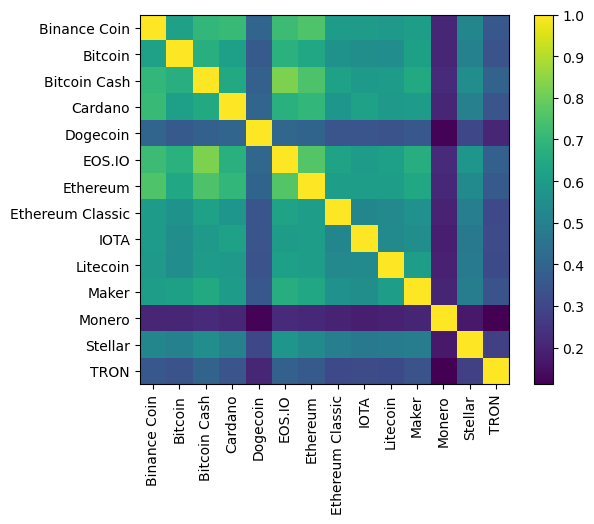

In [8]:
# time frame selection: from datetime to timestamp
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

all2021=pd.DataFrame([])
for asset_id, asset_name in zip(info.Asset_ID, info.Asset_Name):
    asset=ctrain[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    asset=asset.loc[totimestamp("01/01/2021"):totimestamp("21/09/2021")]
    asset=asset.reindex(range(asset.index[0],asset.index[-1]+60,60), method="pad")
    lret=log_return(asset.Close.fillna(0))[1:]
    all2021=all2021.join(lret,rsuffix=asset_name,how="outer")
    
plt.imshow(all2021.corr());
plt.yticks(info.Asset_ID, info.Asset_Name.values)
plt.xticks(info.Asset_ID, info.Asset_Name.values,rotation="vertical");
plt.colorbar(cmap="coolwarm")

<h1 id="h3">
    <div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#ffeea9;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px"> 3.✨  Price History      
<a class="anchor-link" href="https://www.kaggle.com/code/fangya/cryptocurrency-data-visualization-arima">¶</a>
</h1>

We will use the Closing Price and Candlestick graph to capture the trends of the crypto currency.

 <h2 style="color:#e96d13;"> 3.1 Closing Price Trend in 2024 </h2>

we will impute the missing time value using the "pad" method and present the overall closing price for Bitcoin, Etherum, Carnado 
 

In [9]:
# Impute Missing Time Value
def c_time_sub(asset_id, data=ctrain):
    df=data[ctrain["Asset_ID"]==asset_id].set_index("timestamp")
    df=df.reindex(range(df.index[0],df.index[-1]+60,60), method="pad")
    return df

In [10]:
#1. Subgroup Bitcoin
btc=c_time_sub(asset_id=1)
(btc.index[1:] -btc.index[:-1]).value_counts().head()
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [11]:
#2. Subgroup Ethereum
eth=c_time_sub(asset_id=6)
(btc.index[1:] -btc.index[:-1]).value_counts().head()
eth.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
1514764980,6,120.0,738.3325,745.12,730.00,737.5025,174.138031,737.994457,-0.004206
1514765040,6,156.0,737.2225,744.69,728.93,737.1025,165.383926,737.303631,-0.002205
1514765100,6,118.0,736.5300,743.80,727.11,735.7050,193.078039,736.163026,-0.001744


In [12]:
#3. Subgroup Cardano
ada=c_time_sub(asset_id=3)
(ada.index[1:] -ada.index[:-1]).value_counts().head()
ada.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1523956260,3,16.0,0.260000,0.260990,0.260000,0.260000,32230.832200,0.260200,-0.004612
1523956320,3,28.0,0.260000,0.260990,0.259852,0.260000,18711.228600,0.260037,0.000387
1523956380,3,9.0,0.260000,0.260000,0.258700,0.258700,6831.405700,0.259515,-0.005415
1523956440,3,5.0,0.259999,0.259999,0.259870,0.259998,4414.874062,0.259884,-0.005415
1523956500,3,9.0,0.259997,0.259997,0.259000,0.259997,10797.813800,0.259997,0.000385


In [13]:
# Create time interval for 2024
def dur(start,end,data):
    df=data.loc[totimestamp(start): totimestamp(end)]
    return df

btc2021= dur(start="01/01/2021", end="21/09/2024", data=btc)
eth2021= dur(start="01/01/2021", end="21/09/2024", data=eth)
ada2021= dur(start="01/01/2021", end="21/09/2024", data=ada)

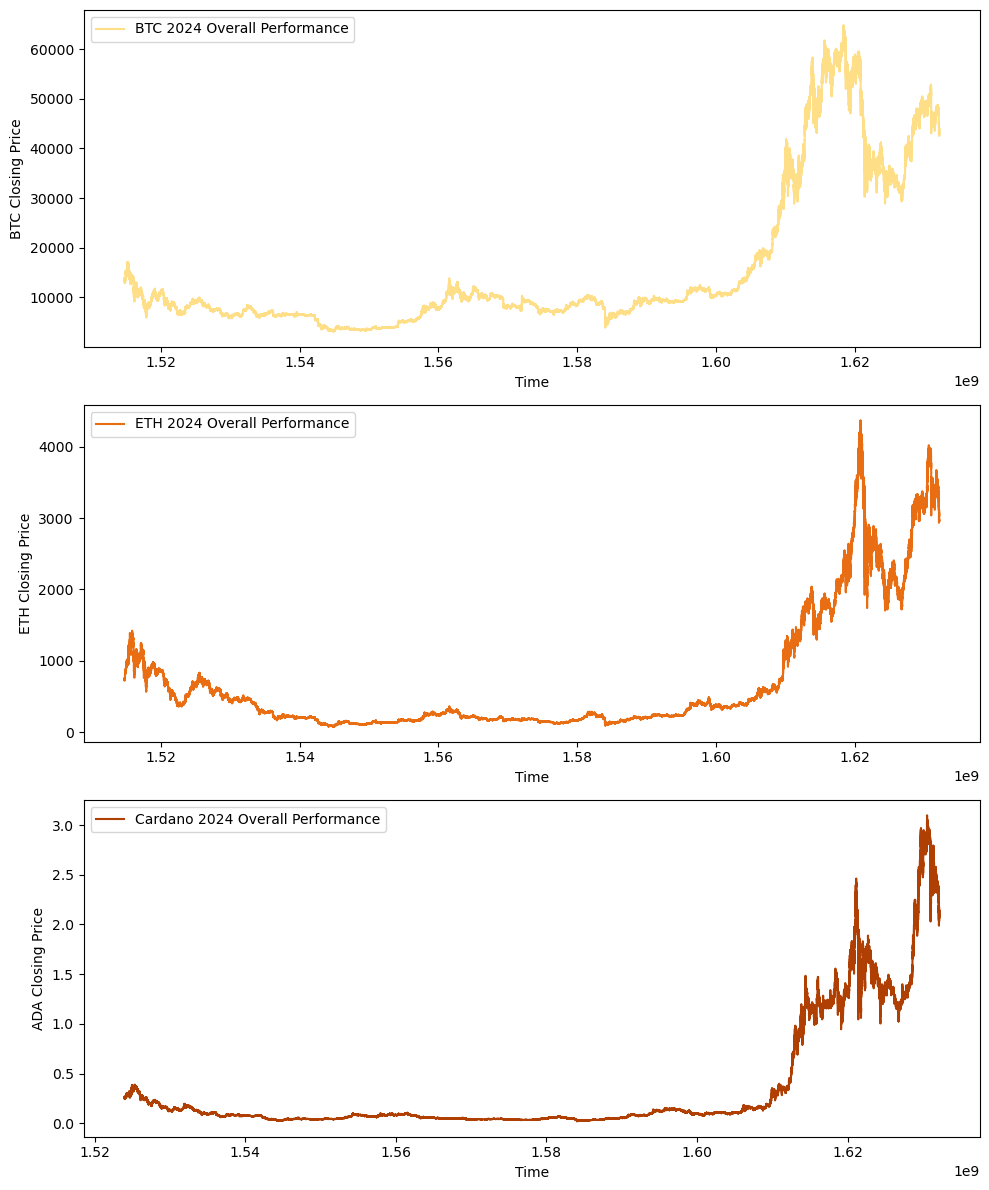

In [14]:
# Plot the Closing Price for BTC, ETH, ADA
f= plt.figure(figsize=(10,12))  

def gplot(no , data, price, label, ylabel, color):
    ax=f.add_subplot(no)
    plt.plot(data[price], label=label, color=color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    return plt

gplot(no=311, data=btc, price="Close" , label="BTC 2024 Overall Performance", ylabel="BTC Closing Price", color="#fede86")
gplot(no=312, data=eth, price="Close" ,label="ETH 2024 Overall Performance", ylabel="ETH Closing Price", color="#e96d13")
gplot(no=313, data=ada, price="Close" ,label="Cardano 2024 Overall Performance", ylabel="ADA Closing Price", color="#b03f03")

plt.tight_layout()
plt.show()

 <h2 style="color:#f88a21;"> 3.2 Return Rate for BTC, ETH, and ADA </h2>
we see the crypto currency price went up dramatically regardless of the type, we would like to investigate one step further for the Target variable.
*Target : 15 minute resudualized returns.

*Residual Return: An asset's residual return equals its excess return minus beta times the benchmark excess return.

As we can see ETH, and BTC residual return are relatively stable compared to ADA.
This might be a good implication that if the investor would take short time trading opportunities, ADA is a better choice. 

If the investor is risk averse, BTC or ETH will be a better fit

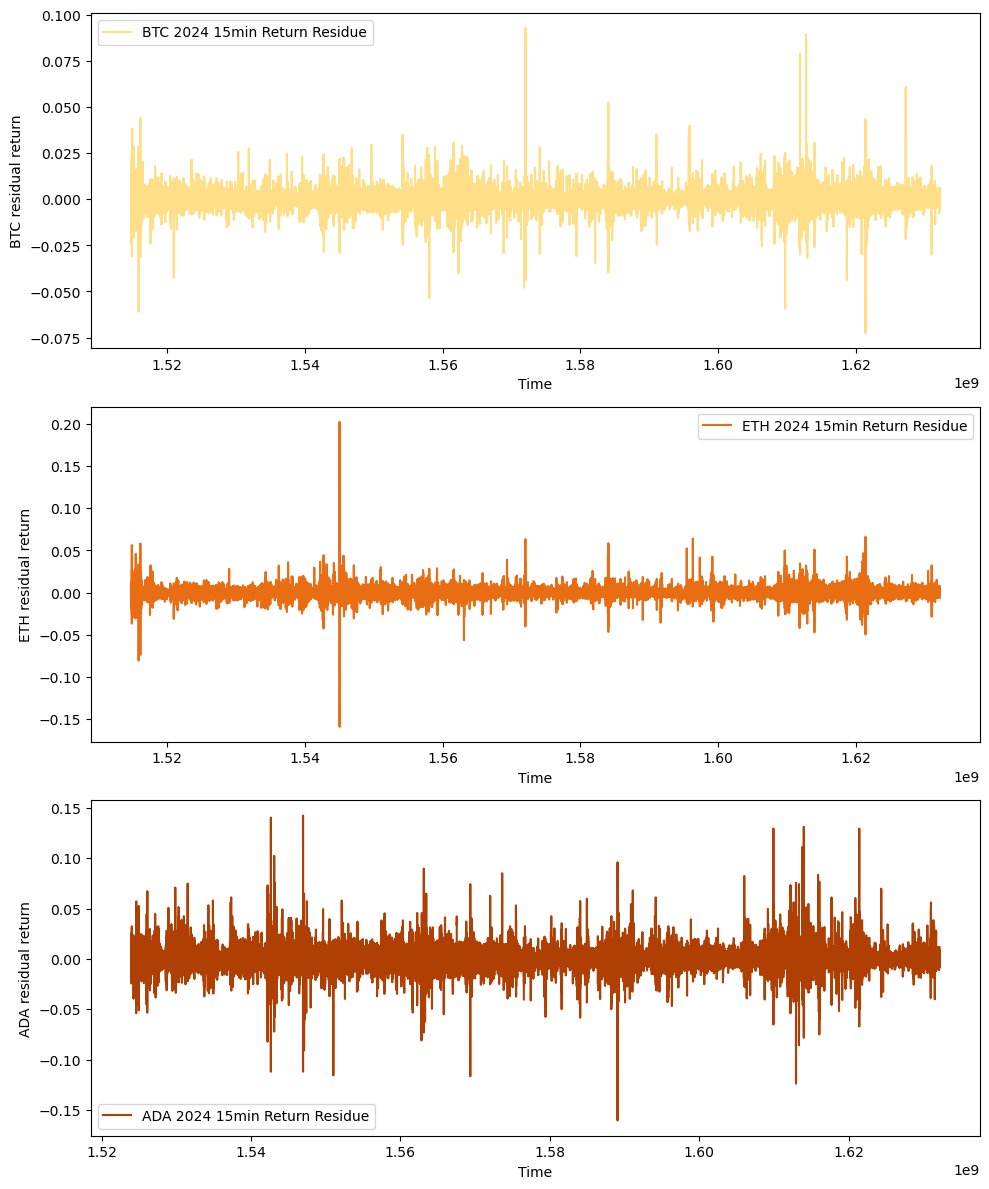

In [15]:
f= plt.figure(figsize=(10,12))  
gplot(no=311, data=btc, price="Target" , label="BTC 2024 15min Return Residue", ylabel="BTC residual return", color="#fede86")
gplot(no=312, data=eth, price="Target" ,label="ETH 2024 15min Return Residue", ylabel="ETH residual return", color="#e96d13")
gplot(no=313, data=ada, price="Target" ,label="ADA 2024 15min Return Residue", ylabel="ADA residual return", color="#b03f03")


plt.tight_layout()
plt.show()

 <h2 style="color:#f88a21;"> 3.3 Candlestick Chart </h2>
Candlestick charts are used by traders to determine possible price movement based on past patterns.

In [16]:
def c_chart(data,label):
    candlestick = go.Figure(data = [go.Candlestick(x =data.index, 
                                               open = data[('Open')], 
                                               high = data[('High')], 
                                               low = data[('Low')], 
                                               close = data[('Close')])])
    candlestick.update_xaxes(title_text = 'Time',
                             rangeslider_visible = True)

    candlestick.update_layout(
    title = {
        'text': '{:} Candelstick Chart'.format(label),
        "y":0.8,
        "x":0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    candlestick.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    return candlestick

btc1.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [17]:
%matplotlib inline
btc_candle=c_chart(btc1[-90:], label="BTC Price")
btc_candle.show()

<h3 style="color:#e96d13;"> ETH Candlestick </h3>

We randomly pick a time interval for the ETh price, we see an over sold around 1:50am, and an overbuy around 02:05 am.

In [18]:
eth_candle=c_chart(eth1[100888:100988], label="ETH Price ")
eth_candle.show()

<h3 style="color:#e96d13;"> ADA Candle Stick </h3>

Overbuying around 16:20

In [19]:
%matplotlib inline
ada_candle=c_chart(eth1[-500:-400], label="ETH Price ")
ada_candle.show()


<h1 id="h4">
    <div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#ffeea9;
           font-size:100%;
           font-family:Verdana;
           letter-spacing:0.5px"> 4.🌅  ARIMA Model   
<a class="anchor-link" href="https://www.kaggle.com/code/fangya/cryptocurrency-data-visualization-arima">¶</a>
</h1>

In [20]:
# Function to Subset the Price variables
def mini_data(data):
    df=data[["Close","Low","High","Open"]]
    return df

btc1_mini=mini_data(btc1)
eth1_mini=mini_data(eth1)
ada1_mini=mini_data(ada1)
btc1.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2018-01-01 00:04:00,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2018-01-01 00:05:00,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


 <h2 style="color:#e96d13;"> 4.1 Seasonal Decomposition</h2> 

BTC Seasonal Decomposition


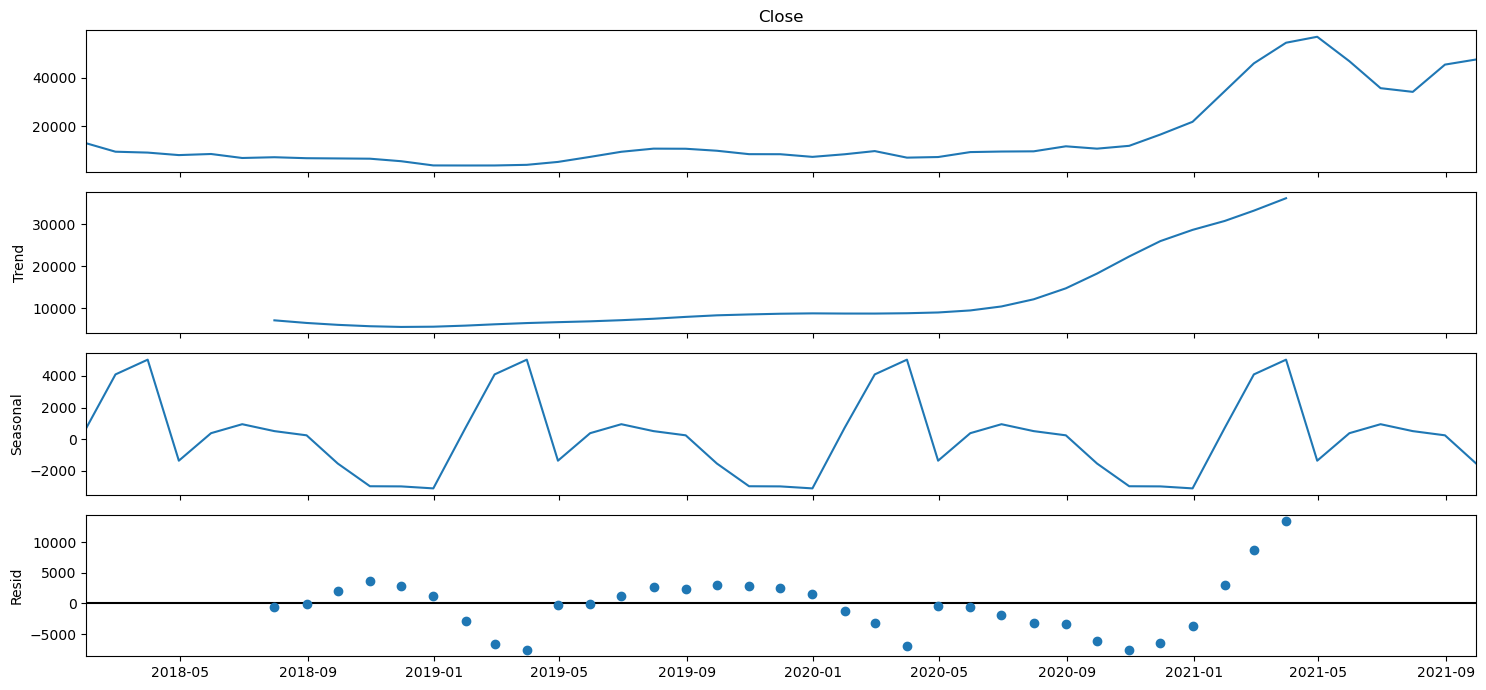

In [21]:
# Function to Plot
plt.rcParams["figure.figsize"]=(15,7)

def season_df(data, label):
    df=data.resample("M").mean()
    seasonal_decompose(df.Close).plot()
    print(label)
    return plt.show()

season_df(data=btc1_mini, label="BTC Seasonal Decomposition")

ETH Seasonal Decomposition


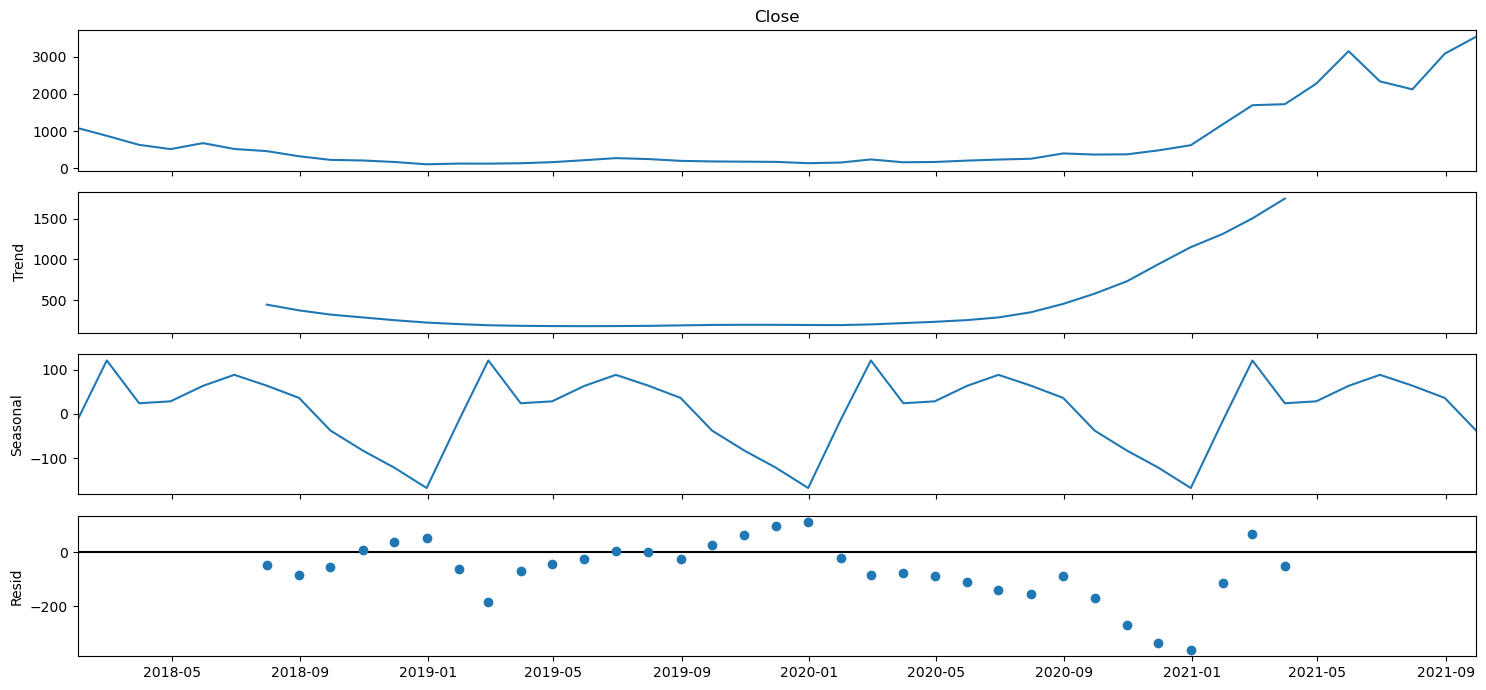

In [22]:
#ETH Seasonal Plot
season_df(data=eth1_mini, label="ETH Seasonal Decomposition")

ADA Seasonal Decomposition


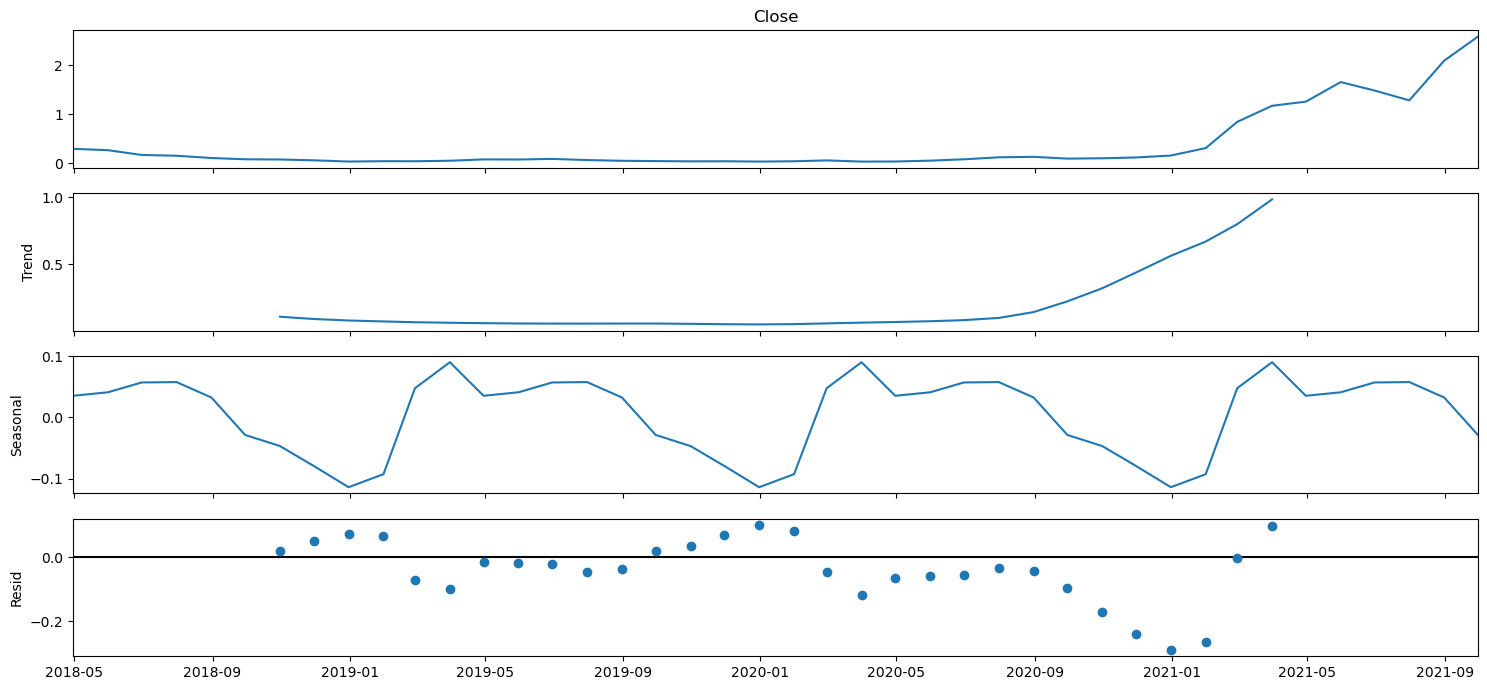

In [23]:
#ADA seasonal decompostion
season_df(data=ada1_mini, label="ADA Seasonal Decomposition")

 <h2 style="color:#e96d13;"> 4.2 Box - Cox Transformation </h2>

In [24]:
#Box-Cox Transformation
btc_month=btc1_mini.resample("M").mean()
btc_month["close_box"], lmbda=stats.boxcox(btc_month.Close)

#btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)

In [25]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [26]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

  parameters         aic
3     (1, 0) -446.108784
1     (0, 1) -445.320473
6     (2, 0) -444.145557
4     (1, 1) -444.130525
2     (0, 2) -442.735686
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   45
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 225.054
Date:                Thu, 05 Dec 2024   AIC                           -446.109
Time:                        13:36:34   BIC                           -442.540
Sample:                    01-31-2018   HQIC                          -444.785
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3821      0.133      2.874      0.004      

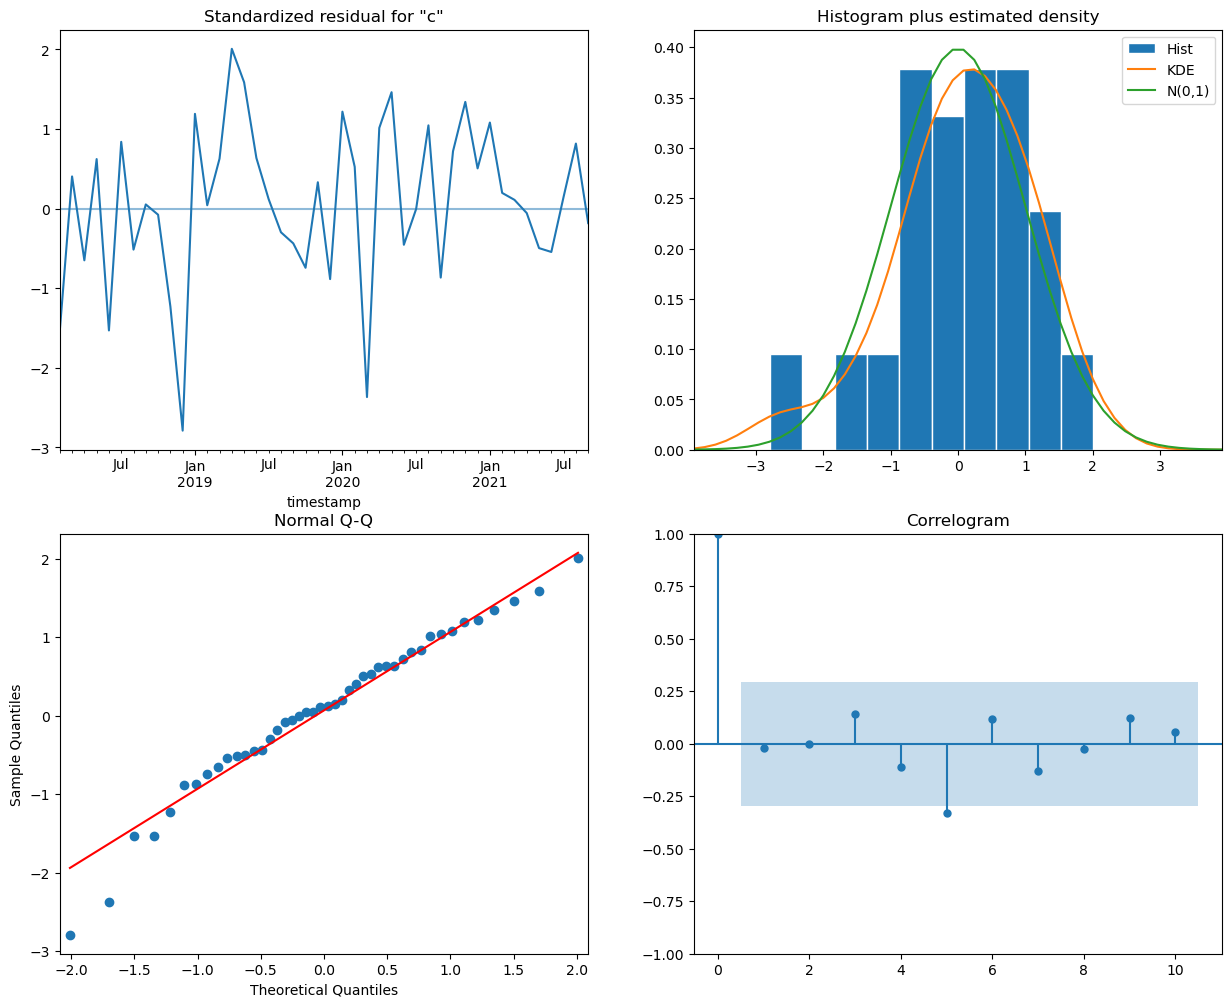

In [27]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

 <h2 style="color:#e96d13;"> 4.2 ARIMA for Bitcoin </h2>

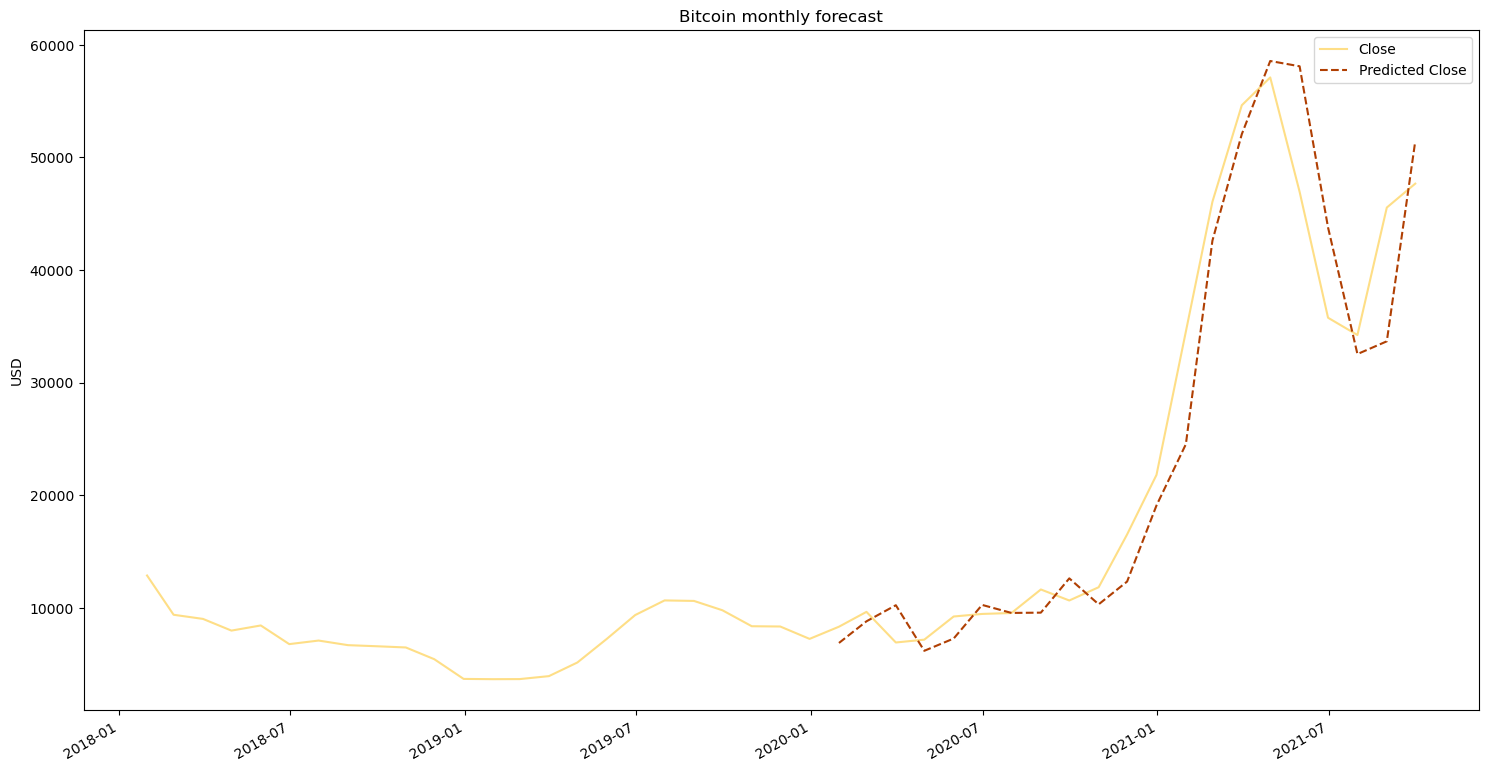

In [29]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2024, 6, 20), datetime(2024, 7, 20), datetime(2024, 8, 21), datetime(2024, 9, 21)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2020, 1, 31), end=datetime(2024, 5, 31)), lmbda)
plt.figure(figsize=(18,10))
btc_month_pred.Close.plot(color='#fede86')
btc_month_pred.forecast.plot(color='#b03f03', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()